# SumTree to Accelerate Sampling

Now that you have learned about the Prioritized Experience Replay, we have another problem. As our cached experiences grow, the sampling process also linearly grows, because sampling is an $O(N)$ process! If our case we have $N$ samples, and each has some probability (the priority) to be sampled. There are a few ways the sampling process can be implemented, but here is one of the most common: The Cumulative Sum Method

### Cumulative Sum

Lets say we had $N = 4$, and each thing had the following probabilities:

$$P = [0.1, 0.2, 0.4, 0.3]$$

This means that the probability of selecting the first item should be 0.1, the second item should be 0.2, and so on. To sample from this, we can simply do a cumulative sum:

$$\text{Cumulative } P = [0.1, 0.3, 0.7, 1.0]$$

Now look at our Regions:

- $0 \rightarrow 0.1$
- $0.1 \rightarrow 0.3$
- $0.3 \rightarrow 0.7$
- $0.7 \rightarrow 1.0$

If we sample a random uniform number between the min and max cumulative value (0 and 1 in this case), then the probability of it falling in the first region is $\frac{0.1-0}{1}$, the second region would be $\frac{0.3-0.1}{1}$, ...

Notice these are the same probabilities as before! Therefore, doing a cumulative sum and then a uniform sample and finding the region our sample falls in is equivalent to sampling from the original distribution with their probabilities. 

### Lets Implement It!

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.display import Video

def sample_dist(probabilities):

    ### Convert Probabiltiies To Segments Btwn [0,1] ###
    ### [0.1, 0.2, 0.4, 0.3] -> [0.1 0.3 0.7 1. ] ###
    cumulative_probs = np.cumsum(probabilities)

    ### Sample Value Btwn [0,1] ###
    sample_val = np.random.uniform()

    ### Find Which Segment We Selected ###
    for idx, p in enumerate(cumulative_probs):
        if sample_val < p:
            return idx
        
    
probs = np.array([0.1, 0.2, 0.4, 0.3])
sample = sample_dist(probs)
sample

2

### Do our Distributions Match?

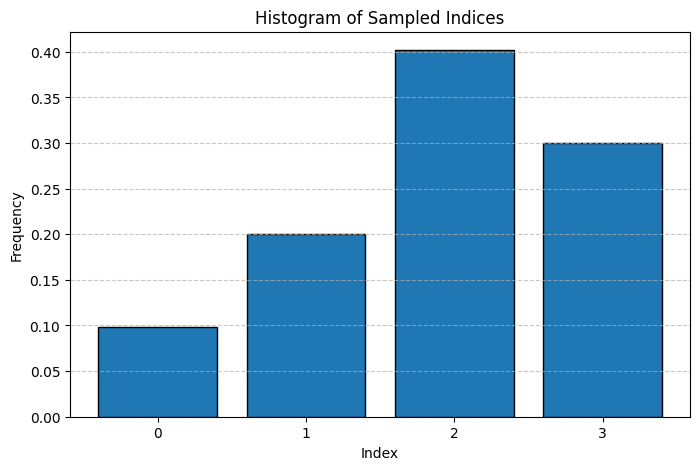

In [2]:
samples = [sample_dist(probs) for _ in range(10000)]

plt.figure(figsize=(8, 5))
plt.hist(samples, bins=np.arange(len(probs)+1)-0.5, rwidth=0.8, density=True, edgecolor='black')
plt.xticks(range(len(probs)))
plt.xlabel('Index')
plt.ylabel('Frequency')
plt.title('Histogram of Sampled Indices')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Looks like it does! Therefore this is a totally valid way to sample our data. In our original PER implementation, we use ```torch.multinomial``` but they are most likely doing something very similar in the backend! But as you can tell, doing a Cumulative Sum and then looping over to find the region are both $O(N)$ operations! 

But if we are just searching for which region our randomly sampled uniform falls in, then why not leverage some better search methods, like Binary Search with $\logN$ complexity? And this leads us to the SumTree!

## SumTree Data Structure

The SumTree is very simple at heart. Just like in our Replay Buffer from before, we have to provide some ```capacity``` parameter that identifies how many samples do we want to store? Let just look at the SumTree in general for now, we can add in the few extra things we need for RL later!

### Its just a Binary Tree!

<img src="sumtree_vis/tree.png" alt="drawing" width="400"/>

This is just a regular binary tree, but what makes it a SumTree is that the parent node is the sum of its children! Our top-most node (the root) is the total sum of everything. There are two things we need to be able to do with this tree:

- Identify region a randomly sampled number falls in
- Update the sums

#### Get Region

Using our previous logic, what are the regions:

- $0 \rightarrow 2$
- $2 \rightarrow 6$
- $6 \rightarrow 9$
- $9 \rightarrow 16$

Hopefull you can start to see some similarities between what we had done earlier with our regions, and how that information is encoded in the same way in this graph!


In this graph, we see the max node value is 16 (effectively our total cumulative sum of all our input leaf elements). Lets randomly sample a number between 0 and 16:

##### Random Sample: 3

Lets say we randomly sampled 3. Then I know right off the bat that I should be inside the $2 \rightarrow 6$ region! But looping through all the regions and checking was an $O(N)$ operation! Therefore we need to use the structure of this tree instead. The logic is very simple though!

Notice the nodes 6 and 10. 6 is the cumulative sum of the first two leaf nodes in our tree. This means, if we had sampled anything less than or equal to 6, that is the direction we should go in. This means, the entire other branch (greater than 6) **DOESNT NEED TO BE SEARCHED!!**

<img src="sumtree_vis/step1_3.png" alt="drawing" width="300"/>

Now we are at the 6 node, which has the children 2 and 4. We do the same check again, is 3 (our sampled value) less than 2? No! Therefore it cannot be in the $0 \rightarrow 2$ region. And the only choice left is going to node 4, which is our $2 \rightarrow 6$ regions (where the 3 does exist). And thats it!! We have sampled that region that we are looking for. 

<img src="sumtree_vis/step2_3.png" alt="drawing" width="300"/>

This process is no different than what we had done earlier, its just by using the Binary Tree, we are able to limit our search by ignoring branches that dont meet our condition. In the older method, we would check everything (brute force). 

But there is one more catch, what happens when we go right at earlier nodes?

##### Random Sample: 12
<img src="sumtree_vis/start_12.png" alt="drawing" width="300"/>

Same setup, same everything. We randomly sampled a number between 0 and 16 and this time we got 12. Well, is 12 less than 6? Of course not! So we have to go down the right branch instead!

<img src="sumtree_vis/step1_12.png" alt="drawing" width="300"/>

But now here is the problem. The left branch (branch from node 6) represents the cumulative sum upto 6. The right branch represents the cumulative sum from 6 \rightarrow 16, but the actual amount of that sum is 10. Therefore our comparisons have to be on the basis that this branch goes from 0 \rightarrow 10 and not 6 \rightarrow 16. So we must offset our value, we passed in 12, but now that we have gone down the right branch, we can offset our 6 \rightarrow 16 range to 0 \rightarrow 10 by subtracting 6 from our value!

After that everything is the same. We can check that 6 (our updated value subtracting 6 from 12) is not less than 3, therefore we go down the right branch, sampling the number 7

<img src="sumtree_vis/step2_12.png" alt="drawing" width="300"/>

Again, all of this is doing **EXACTLY THE SAME THING**. We are still finding regions in our cumulative sum, we are just doing it smarter now. 

### Updating the Graph

As you can tell, our input values are just the bottom leaf nodes. All other nodes represent the cumulative sums. But as we know, when we do our PER we will update to update these priorities, which means we need to update the leaf values. Lets say we change our leaf node 2 to a 5 (thats the new priority we calcualted. Its not as simple as just change the node, we need to push that upstream as well. 

If we change the 2 to a 5, then its sum with 4 will go from 6 to 9, and the total will go from 16 to 19! 2 to 5 was a difference of 3, so we ended up pushing the change of 3 upstream to all of its parent nodes. 

<img src="sumtree_vis/graph_update.png" alt="drawing" width="400"/>

### Represent the Graph as a Vector

There are actually a bunch of ways to implement this. We could create a node and some pointers, but honestly the simplest way is represent the graph as a vector. This works because we can do some simple indexing to make this work out. 

First of all, we need to know that a binary tree with $N$ leaves (which will be the number of samples we want to store in our buffer) has $2N+1$ Nodes. This is easy to verify, in our case our graph has 4 leaves, and we count 7 nodes. You can try this for other amounts, but this always is true!

Lets look at a tree with no values, just some variables to understand the organization:

<img src="sumtree_vis/var_graph.png" alt="drawing" width="400"/>

We have our 4 Leaf Nodes $A, B, C, D$, $E=A+B$, $F=C+D$, $G=E+F$

What we will do is create a empty vector of length $2N+1$ (in this case 7) for the 7 nodes that we have. Then we will populate it in the following way:

- Leaf Node Indexes: $N-1 \rightarrow 2N-2$
- Root Node Index: $0$
- For any node at index K:
    - Left Child is at $2*K + 1$
    - Right Child is at $2*K + 2$
- The parent node for any child is at $(K-1)//2$

 More specifically itll look like this:

 <img src="sumtree_vis/array_setup.png" alt="drawing" width="400"/>

 So does it follow our rules?

- $G$ is our root node, and we find it at index 0
- $A,B,C,D$ are our leaf nodes and we find them from indexes $N-1=3 \rightarrow 2N-2=6$ because $N=4$ for our 4 leaf nodes
- $A$ is at index 3. Its parent would be at $(3-1)//2)=1$ which is $E$ and the parent of $A$! Similarly, $E$ is at index 1, its parent would be at $(1-1)//2=0$ which is the index for $G$ which is the parent for $E$. This works the same for all other nodes as well
- $E$ is at index 1, its left child node is at $2*1+1=3$ which is the index of its left child $A$. Similarly, $2*1+2=4$ is the index of its right child $B$.

As you can see, with just a few rules on the indexing we can represent an entire tree with a simple array. Again, lots of ways you can implement this, this is just how im doing it!

This method really only works well when you have Complete trees (if your tree was very sparse, you would have lots of unused parts in your array and thats wasted memory). But in this case, our SumTree is always fully complete so its no problem!

### Lets Implement the SumTree

Lets implement everything as described here! One thing to keep in mind is the SumTree only stores the number we want (priority in our case). We also need to store the experience tuple (State, Next_State, Action, ...). We will create a cooresponding array to store this additional information so we can index by the selected experience at the very end. 


In [3]:
class SumTree:

    """
    Simple Array Implementation of SumTree
    """ 

    def __init__(self, N):

        ### Set Max Capacity N (max memories) ###
        ### For a Fully Balanced Tree, This Must Be power of 2 ###
        self.N = 1
        while self.N < N:
            self.N *= 2
        print(f"Set Capacity to {self.N}")

        ### The tree will have 2 * N - 1 nodes ###
        self.tree = torch.zeros((2 * self.N - 1), dtype=torch.float64)

        # ### Empty Array To Store Experiences ###
        # self.experiences = np.zeros(capacity, dtype=object) 

        ### Write Index Is an Integer that indicated the next available slot ###
        ### It ranges from 0 to N-1, and once we hit N, ###
        ### we wrap back around to 0! ###
        self.write_idx = 0

        ### Just a tracker to know how many samples we have, Once we hit N then ###
        ### this wont really matter anymore, as our entries will just be N ###
        self.n_entries = 0

    def total(self):
        """
        The total cumulative sum is stored in the root node
        """
        return self.tree[0]

    def _propagate(self, idx, delta):
        """
        If we added some Delta to our leaf node, we need to 
        propagate that Delta up the chain 
        """
        
        ### Use Our Logic to get from our current index to its parent ###
        parent_idx = (idx - 1)//2

        ### Add the Delta to our node ###
        self.tree[parent_idx] += delta

        ### If we arent at root node yet continue going up the chain ###
        if parent_idx != 0:
            self._propagate(parent_idx, delta)

    def update(self, idx, priority):

        """
        Method to compute our Delta between the new priority and existing priority
        and then propagate that change up the tree 
        """

        ### Compute the Change ###
        delta = priority - self.tree[idx]

        ### Set the New Value (basically adding our delta to the old value) ###
        self.tree[idx] = priority

        ### Propagate the delta up the tree ###
        self._propagate(idx, delta)

    def add(self, priority):

        """
        Method to add a new value to our tree at whatever the 
        write_ptr index is
        """
        ### Get the Tree Index. Our Write Index only goes from 0 -> N-1 ###
        ### But we can only write to our leaf nodes, and our leaf nodes are in ###
        ### indexes N-1 -> 2N-2. So just a simple shift is needed to get our indexes right:

        ### 0 + (N-1) -> (N-1)
        ### (N-1) + (N-1) -> (2N-2)
        tree_idx = self.write_idx + (self.N - 1)
        
        ### Update the rest of the tree accordingly ###
        self.update(tree_idx, priority)

        ### Update Write Index and Wrap ###
        self.write_idx += 1
        if self.write_idx >= self.N:
            self.write_idx = 0

        ### Update Number of Entries in our Tree So Far ###
        if self.n_entries < self.N:
            self.n_entries += 1
            
    def _retrieve(self, idx, sample_value):

        """
        Recursively goes down tree to find which region our 
        sample_value is inside
        """

        ### Index for Right and Left Child Nodes ###
        left_child_idx = 2 * idx + 1
        right_child_idx = 2* idx + 2

        ### If the Child Node Index is outside of our tree, we are on a leaf node ###
        if left_child_idx >= len(self.tree):
            return idx

        ### Logic for Left vs Right Decision As Explained Earlier ###
        if sample_value <= self.tree[left_child_idx]:
            return self._retrieve(left_child_idx, sample_value)
        else:
            return self._retrieve(right_child_idx, sample_value-self.tree[left_child_idx])

    def get(self, sample_value):

        ### Get Our Leaf Index (N-1->2N-2) for whichever was selected based on the sample value ###
        leaf_tree_idx = self._retrieve(idx=0, sample_value=sample_value)

        ### Convert our Leaf Index Back to the original Index ###
        ### Our Leaf Index is (N-1->2N-2) but our data index just goes (0->N-1)
        ### Therefore adjust our index (reverse of what we had done earlier) 

        ### (N-1) - (N-1) -> 0
        ### (2N-2) - (N-1) -> N-1
        data_idx = leaf_tree_idx - (self.N - 1)

        return leaf_tree_idx, self.tree[leaf_tree_idx], data_idx
        
    def __len__(self):
        return self.n_entries

tree = SumTree(64)
for i in range(64):
    tree.add(1)

sample_value = torch.rand(1) * tree.total()
leaf_idx, priority, data_idx = tree.get(sample_value)
print(leaf_idx)
print(priority)
print(data_idx)

Set Capacity to 64
81
tensor(1., dtype=torch.float64)
18


### Was it Worth It?

I wrote a quick benchmark function in ```sumtree_bench.py```. I wont do that code here, its just to see how our time to sample changes based on the number of samples in our buffer and the results are exactly what you expect!

 <img src="sumtree_vis/bench.png" alt="drawing" width="400"/>

### Multiple Traversals

One problem we have with our implementation is that our ```_retrieve``` method can only grab one sample at a time. This means that if we have a batch of 256, we have to for loop through each batch and repeat the traversal every time! When I did this initally, our ```access_memories``` method in the agent looked like this:

```python
def access_memories(self, batch_size, device="cpu"):

    ### WE CANNOT ACCESS MEMORIES BY SIMPLY INDEXING THE ENTIRE BATCH IN ONE GO ###
    ### WE HAVE TO LOOP THROUGH OUR BATCH SIZE AND GET THE SAMPLES ON AT A TIME ###

    ### Get Total Memories from SumTree ###
    total_memories = len(self.sum_tree)

    ### If we dont have enough return None ###
    if total_memories < batch_size:
        return None

    ### Create an Empty Batch ###
    states = []
    next_states = []
    actions = []
    rewards = []
    terminals = []
    indices = []
    priorities = []

    for i in range(batch_size):

        ### Sample a Value between 0 and the total cumulative sum ###
        ### Lower bound is 0 because priorities we saved in there are ###
        ### Always positive! ###
        sample_value = np.random.uniform(0, self.sum_tree.total())

        ### Grab the Sample (returns index in tree, index in data and priority) ###
        tree_idx, priority, data_idx = self.sum_tree.get(sample_value)

        ### Store Tree Index For Future ###
        indices.append(tree_idx)

        ### Store Priority for Future ###
        priorities.append(priority)

        ### Grab Corresponding Data ###
        states.append(self.state_memory[data_idx])
        next_states.append(self.next_state_memory[data_idx])
        actions.append(self.action_memory[data_idx])
        rewards.append(self.reward_memory[data_idx])
        terminals.append(self.terminal_memory[data_idx])

    ### Create the Batched Data ###
    states = torch.stack(states).to(device)
    next_states = torch.stack(next_states).to(device)
    actions = torch.tensor(actions, dtype=torch.long).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    terminals = torch.tensor(terminals, dtype=torch.bool).to(device)
    indices = torch.tensor(indices, dtype=torch.long).to(device)
    priorities = torch.tensor(priorities, dtype=torch.float32).to(device)

    ### Compute IS Weights from Priorities ###
    probabilities = priorities / self.sum_tree.total()
    weights = (total_memories * probabilities) ** (-self.beta)
    weights = weights / weights.max()

    batch = {"states": states,
             "next_states": next_states,
             "actions": actions,
             "rewards": rewards,
             "terminal": terminals,
             "indices": indices, 
             "weights": weights}
            
    return batch
```

We want to avoid this for loop if we can! This is a small optimization we can add in to improve our efficiency of the SumTree:



In [4]:
class ParallelSumTree(SumTree):
    def __init__(self, N):
        super().__init__(N)

    def _retrieve(self, idx, sample_value):

        """
        Rewrite of the _retrieve function to work with a batch of sample_value
        rather than just a single value at a time
        """
        
        ### If idx is 0 integer (at the start) Repeat For the Number of sample_values (batch_size) ###
        if isinstance(idx, int):
            idx = torch.full_like(sample_value, 0, dtype=torch.long)
    
        ### Index for Right and Left Child Nodes ###
        left_child_idx = 2 * idx + 1
        right_child_idx = 2 * idx + 2
        
        ### If the Child Node Index is outside of our tree, we are on a leaf node ###
        ### Because everything is the same depth (balanced tree) this will happen ###
        ### at the same time for all our sample_values! So once of them is ourside ###
        ### the length of our tree, they all will be outside ! ###
        if left_child_idx.min() >= len(self.tree):
            return idx
        
        ### Get the Left and Right Value for each idx at our tree ###
        left_val = self.tree[left_child_idx]
        right_val = self.tree[right_child_idx]
        
        ### For Each idx check if we go left or right ###
        go_left = (sample_value <= left_val)
        go_right = ~go_left
        
        ### Get Update Idx For Next Level, If we want to go left for an idx, then ###
        ### grab the left_idx otherwise grab the right_idx ###
        left_right_idx = go_left * left_child_idx + go_right * right_child_idx
        
        ### Update Sample Values. If we Are Going Left we need the Sample Value ###
        ### that we currently have! If we are going right, we want to subtract the ###
        ### left_idx from our sample value ###
        sample_value = sample_value - left_val * go_right
        
        ### Do it Again! ###
        return self._retrieve(left_right_idx, sample_value)

tree = ParallelSumTree(64)
for i in range(64):
    tree.add(1)

sample_value = torch.rand(4) * tree.total()
leaf_idx, priority, data_idx = tree.get(sample_value)
print(leaf_idx)
print(priority)
print(data_idx)

Set Capacity to 64
tensor([126, 113, 114, 125])
tensor([1., 1., 1., 1.], dtype=torch.float64)
tensor([63, 50, 51, 62])


### Integrating TimeCapsulePER with SumTree

We have now sped up sampling! Lets add it to our TimeCapsulePER implementation now

In [5]:
class TimeCapsuleSumTreePER:

    """
    Simple Class to store and replace memories
    """
    
    def __init__(self, 
                 max_memories, 
                 num_state_features=8, 
                 per_alpha=0.6, 
                 per_beta=0.4,
                 per_beta_increment=1e-4,
                 per_eps=1e-5):

        self.max_memories = max_memories
        self.alpha = per_alpha
        self.beta = per_beta
        self.beta_increment = per_beta_increment
        self.eps = per_eps

        self.state_memory = torch.zeros((self.max_memories, num_state_features), dtype=torch.float32)
        self.next_state_memory = torch.zeros((self.max_memories, num_state_features), dtype=torch.float32)
        self.action_memory = torch.zeros((self.max_memories, ), dtype=torch.long)
        self.reward_memory = torch.zeros((self.max_memories, ), dtype=torch.float32)
        self.terminal_memory = torch.zeros((self.max_memories, ), dtype=torch.bool)

        ###########################
        ### USE ParallelSumTree Instead ###
        # self.sum_tree = SumTree(self.max_memories)
        self.sum_tree = ParallelSumTree(self.max_memories)
        ###########################

    def add_memory(self, state, next_state, action, reward, terminal, td_error):

        #####################################################################################
        ### We Get Our Index From Our Write Index In The SumTree Now, It Handles The Wrap ###
        idx = self.sum_tree.write_idx
        #####################################################################################

        self.state_memory[idx] = torch.tensor(state, dtype=self.state_memory.dtype)
        self.next_state_memory[idx] = torch.tensor(next_state, dtype=self.next_state_memory.dtype)
        self.action_memory[idx] = torch.tensor(action, dtype=self.action_memory.dtype)
        self.reward_memory[idx] = torch.tensor(reward, dtype=self.reward_memory.dtype)
        self.terminal_memory[idx] = torch.tensor(terminal, dtype=self.terminal_memory.dtype)

        ################################################
        ### ADD PRIORITIES (ABSOLUTE TD ERROR + eps) ###
        priority = (abs(td_error) + self.eps) ** self.alpha
        self.sum_tree.add(priority)
        ################################################

    def anneal_beta(self):

        #############################
        ### ADD IN BETA ANNEALING ###
        self.beta = min(1.0, self.beta + self.beta_increment)
        #############################

    def access_memories(self, batch_size, device="cpu"):

        ### WE CANNOT ACCESS MEMORIES BY SIMPLY INDEXING THE ENTIRE BATCH IN ONE GO ###
        ### WE HAVE TO LOOP THROUGH OUR BATCH SIZE AND GET THE SAMPLES ON AT A TIME ###

        ### Get Total Memories from SumTree ###
        total_memories = len(self.sum_tree)

        ### If we dont have enough return None ###
        if total_memories < batch_size:
            return None

        ### Get Sample Values ###
        sample_values = torch.rand(batch_size) * self.sum_tree.total()

        ### Get Sample Indexes from Tree ###
        tree_indexes, priorities, data_indexes = self.sum_tree.get(sample_values)
    
        ### Grab Cooresponding Memories ###
        states = self.state_memory[data_indexes].to(device)
        next_states = self.next_state_memory[data_indexes].to(device)
        actions = self.action_memory[data_indexes].to(device)
        rewards = self.reward_memory[data_indexes].to(device)
        terminals = self.terminal_memory[data_indexes].to(device)

        ### Compute Weights ###
        probabilities = priorities / self.sum_tree.total()
        weights = (total_memories * probabilities) ** (-self.beta)
        weights = weights / weights.max()

        batch = {"states": states,
                 "next_states": next_states,
                 "actions": actions,
                 "rewards": rewards,
                 "terminal": terminals,
                 "indices": tree_indexes, 
                 "weights": weights}
                
        return batch

    def update_priorities(self, tree_indices, updated_td_errors):
        ### Method To Loop Through our Tree Indices and Updated TD Error ###
        ### TO update our priorities in the leaf nodes and upstream nodes ###
        for idx, td_error in zip(tree_indices, updated_td_errors):
            priority = (abs(td_error) + self.eps)**self.alpha
            self.sum_tree.update(idx, priority)
    

### Model Stays the Same

We are still doing a simple Dueling DQN Setup!

In [6]:
class DuelingDQN(nn.Module):
    def __init__(self,
                 input_state_features=8, 
                 num_actions=4,
                 hidden_features=128):
        
        super(DuelingDQN, self).__init__()

        self.fc1 = nn.Linear(input_state_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features,hidden_features)

        self.value = nn.Linear(hidden_features, 1)
        self.advantage = nn.Linear(hidden_features, num_actions)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        value = self.value(x)
        advantage = self.advantage(x)
        advantage_mean = advantage.mean(dim=-1, keepdim=True)
        advantage = advantage - advantage_mean
        Q = value + advantage 
        return Q

### Update Agent

Lets get our Agent to Use this New SumTree TimeCapsule!

In [7]:
class Agent:
    def __init__(self,
                 max_memories=100000,
                 discount_factor=0.99, 
                 learning_rate=0.001,
                 input_state_features=8, 
                 num_actions=4,
                 hidden_features=128,
                 epsilon=1.0, 
                 epsilon_decay=0.001, 
                 min_epsilon=0.05,
                 per_alpha=0.6, 
                 per_beta=0.4,
                 per_beta_increment=1e-4,
                 per_eps=1e-5,
                 device="cpu"):

        self.max_memories = max_memories
        self.discount_factor = discount_factor 
        self.learning_rate = learning_rate
        self.input_state_features = input_state_features
        self.num_actions = num_actions
        self.action_space = np.arange(self.num_actions)
        self.hidden_features = hidden_features
        self.epsilon = epsilon 
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon 
        self.device = device

        self.DQN = DuelingDQN(self.input_state_features, self.num_actions, self.hidden_features).to(device)
        self.DQN_NEXT = DuelingDQN(self.input_state_features, self.num_actions, self.hidden_features).to(device)
        self.DQN_NEXT.load_state_dict(self.DQN.state_dict())
        self.DQN_NEXT.eval()
        
        self.optimizer = optim.Adam(self.DQN.parameters(), lr=self.learning_rate)


        self.loss_fn = nn.MSELoss(reduction="none")

        ##############################
        ### UPDATE OUR TIMECAPSULE ###
        self.timecapsule = TimeCapsuleSumTreePER(self.max_memories, self.input_state_features)
        ##############################

    def select_action(self, state):


        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, device=self.device)
            
        if state.dim() == 1:
            state = state.unsqueeze(0)
            
        assert state.shape[-1] == self.input_state_features, f"Passing {state.shape[-1]} features, expect {self.input_state_features}"
        
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            self.DQN.eval()
            with torch.no_grad():
                Q_s_a = self.DQN(state)
            action = torch.argmax(Q_s_a).item()
            self.DQN.train()

        return action

    def update_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

    def inference(self, state, device="cpu"):

        self.DQN = self.DQN.to(device)
        self.DQN.eval()
        
        with torch.no_grad():
            Q_s_a = self.DQN(state.to(device))
            
        return torch.argmax(Q_s_a).item()
        
    def update_target_network(self):
        self.DQN_NEXT.load_state_dict(self.DQN.state_dict())

    def train_step(self, batch_size):

        batch = self.timecapsule.access_memories(batch_size, self.device)
        
        if batch is None:
            return None

        self.DQN.train()
        q_estimate = self.DQN(batch["states"])
        q_estimate = torch.gather(q_estimate, index=batch["actions"].unsqueeze(-1), dim=-1).squeeze(-1) 
   
        with torch.no_grad():

            next_q_values = self.DQN(batch["next_states"])
            next_actions = torch.argmax(next_q_values, dim=-1, keepdim=True)
            next_q_values_target = self.DQN_NEXT(batch["next_states"])
            max_q_next_estimate = next_q_values_target.gather(dim=-1, index=next_actions).squeeze(-1)

        td_target = batch["rewards"] + self.discount_factor * max_q_next_estimate * (~batch["terminal"])

        td_error = td_target - q_estimate 
        loss = self.loss_fn(td_target, q_estimate)
        loss = batch["weights"].to(loss.device) * loss
        loss = loss.mean()

        #######################################
        ### UPDATE PRIORITIES FOR THIS BATCH ###
        updated_priorities = td_error.detach().cpu().abs()
        self.timecapsule.update_priorities(batch["indices"], updated_priorities)
        #######################################

        self.timecapsule.anneal_beta()

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.DQN.parameters(), max_norm=1.0)
        self.optimizer.step()
        self.update_epsilon()


### Trainer Stays the Same! 

In [8]:
def trainer(env, 
            num_games=500,
            update_target_freq=5,
            min_reward=200, 
            game_tolerance=10,
            max_memories=100_000,
            discount_factor=0.99, 
            learning_rate=0.001,
            batch_size=64,
            input_state_features=8, 
            num_actions=4,
            hidden_features=128,
            epsilon=1.0, 
            epsilon_decay=0.999, 
            min_epsilon=0.05,
            log_freq=5, 
            running_avg_steps=25,
            per_alpha=0.6, 
            per_beta=0.4,
            per_beta_increment=1e-4,
            per_eps=1e-5,
            device="cpu"):

    agent = Agent(max_memories=max_memories,
                  discount_factor=discount_factor, 
                  learning_rate=learning_rate,
                  input_state_features=input_state_features, 
                  num_actions=num_actions,
                  hidden_features=hidden_features,
                  epsilon=epsilon, 
                  epsilon_decay=epsilon_decay, 
                  min_epsilon=min_epsilon,
                  per_alpha=per_alpha, 
                  per_beta=per_beta,
                  per_beta_increment=per_beta_increment,
                  per_eps=per_eps,
                  device=device)

    ending_tol = 0

    log = {"scores": [], 
           "running_avg_scores": []}

    for i in range(num_games):
        
        score = 0
        step = 0
        state, _ = env.reset()
        done = False

        while not done:

            action = agent.select_action(state)
            next_state, reward, terminal, truncated, _= env.step(action)
            done = terminal or truncated

            score += reward

            ######################################################################################################
            ### We are normalizing the max to always be 1 (the cumulative sum) so we can set the TD error of new ###
            ### samples to be 1 so they are quickly computed in our computations and set with their true priority ###
            td_error = 1.0
            ######################################################################################################
            
            agent.timecapsule.add_memory(state, next_state, action, reward, done, td_error)
            agent.train_step(batch_size)

            if step % update_target_freq == 0:
                agent.update_target_network()

            step += 1
            state = next_state

        log["scores"].append(score)
        running_avg_score = np.mean(log["scores"][-running_avg_steps:])
        log["running_avg_scores"].append(running_avg_score)
        
        if i % log_freq == 0:
            print(f"Game #: {i} | Score: {score} | Moving Avg Scores: {running_avg_score} | Epsilon: {agent.epsilon}")
    
        if score >= min_reward:
            ending_tol += 1

            if ending_tol == game_tolerance:
                break
        else:
            ending_tol = 0
            
    print("Completed Training")
    return agent, log

device = "cuda" if torch.cuda.is_available() else "cpu"
env = gym.make("LunarLander-v3", render_mode="rgb_array")
agent_per, log_per = trainer(env, device=device)

Set Capacity to 131072
Game #: 0 | Score: -79.56472235532007 | Moving Avg Scores: -79.56472235532007 | Epsilon: 0.996005996001
Game #: 5 | Score: -152.173338368215 | Moving Avg Scores: -215.60777413798732 | Epsilon: 0.6063789448611848
Game #: 10 | Score: -85.5317728258036 | Moving Avg Scores: -161.7629547421213 | Epsilon: 0.14749556991243082
Game #: 15 | Score: -104.03690700947614 | Moving Avg Scores: -150.05785422105396 | Epsilon: 0.05
Game #: 20 | Score: -118.13605330961026 | Moving Avg Scores: -129.5661133955855 | Epsilon: 0.05
Game #: 25 | Score: -30.272279048638612 | Moving Avg Scores: -120.64127817418124 | Epsilon: 0.05
Game #: 30 | Score: -188.95899369106021 | Moving Avg Scores: -84.96086963017193 | Epsilon: 0.05
Game #: 35 | Score: -52.91854137613435 | Moving Avg Scores: -82.89612984159231 | Epsilon: 0.05
Game #: 40 | Score: -98.531811083249 | Moving Avg Scores: -67.84077537347024 | Epsilon: 0.05
Game #: 45 | Score: 12.057118585917365 | Moving Avg Scores: -57.783140007006004 | 

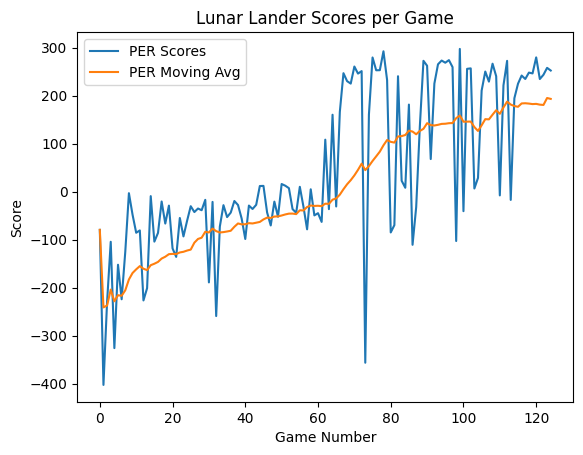

In [9]:
plt.plot(log_per["scores"], label="PER Scores")
plt.plot(log_per["running_avg_scores"], label="PER Moving Avg")
plt.title("Lunar Lander Scores per Game")
plt.xlabel("Game Number")
plt.ylabel("Score")
plt.legend()
plt.show()

In [12]:
def record_game(env, agent, prefix, device="cuda"):

    env = gym.wrappers.RecordVideo(env, 
                                   video_folder="./savevideos", 
                                   video_length=0, 
                                   disable_logger=True,
                                   name_prefix=prefix)

    done = False
    state, _ = env.reset()
    
    while not done:

        ### Get Predicted Action ###
        action = agent.inference(torch.tensor(state).unsqueeze(0))

        ### Step in Environment ###
        new_state, reward, terminal, truncate, _ = env.step(action)
        done = terminal or truncate 
        
        ### State is our New State ###
        state = new_state
        
    env.close()
    
record_game(env, agent_per, prefix="dueling_q_learning_stable")

Video("savevideos/dueling_q_learning_stable-episode-0.mp4", embed=True)

### Thats It!

We have now implemented a faster sampling method! Nothing really changed from earlier its just a better algorithm. But, you will only see benefits for this for massive memory sizes. The reality is that, indexing in Numpy (which is running C/C++ in the backend) to grab our batches, will be faster than python for loops. You would be better off trying to utilize something like [yamoling/sumtree](https://github.com/yamoling/sumtree) for a Rust implementation of this or the optimized Prioritized Replay Buffer found in [torchrl](https://pytorch.org/rl/main/tutorials/rb_tutorial.html#tuto-rb-prb)